# 1/2 manually build map

In [1]:
import rosbag
import math
import numpy as np
import statistics as sta
import enum

'''gps'''
import utm
from pyproj import Proj
import shapefile

'''plot tool'''
import matplotlib.pyplot as plt

'''image tool'''
import cv2

In [2]:
bag_source_dir = '/home/ncslaber/110-1/211002_allLibrary/image_bag/'
file_name = {'middle':'2021-10-02-17-54-09', 'front_right':'2021-10-02-17-03-14', 
            'middle_right':'2021-10-02-17-29-15', 'back_left':'2021-10-03-17-48-23', 
             'front_left':'2021-07-25-18-23-39', 'middle_middle':'2021-10-09-16-49-04'}
lat_dict = {}
lng_dict = {}
for item in file_name.keys():
    try:

        topics = ['/navsat/fix']
        
        bag_source_file = bag_source_dir + file_name[item] + '.bag'
        print('Start reading: {}'.format(bag_source_file))
        bag = rosbag.Bag(bag_source_file, 'r')
        
        lat_dict[item] = list()
        lng_dict[item] = list()
        
        for topic, msg, t in bag.read_messages(topics=topics):
            if topic == '/navsat/fix':
                if not math.isnan(msg.latitude) and not math.isnan(msg.longitude):
                    lat_dict[item].append(msg.latitude)
                    lng_dict[item].append(msg.longitude)
                else:
                    print(msg.latitude, msg.longitude)

                   
        bag.close()
                
    except:
            print('error with: {}'.format(bag_source_file)) 

Start reading: /home/ncslaber/110-1/211002_allLibrary/image_bag/2021-10-02-17-54-09.bag
Start reading: /home/ncslaber/110-1/211002_allLibrary/image_bag/2021-10-02-17-03-14.bag
Start reading: /home/ncslaber/110-1/211002_allLibrary/image_bag/2021-10-02-17-29-15.bag
Start reading: /home/ncslaber/110-1/211002_allLibrary/image_bag/2021-10-03-17-48-23.bag
Start reading: /home/ncslaber/110-1/211002_allLibrary/image_bag/2021-07-25-18-23-39.bag
Start reading: /home/ncslaber/110-1/211002_allLibrary/image_bag/2021-10-09-16-49-04.bag


In [4]:
def transform_to_utm_npy(lat, lng):
    
    _, _, zone, R = utm.from_latlon(lat[0], lng[0])
    proj = Proj(proj='utm', zone=zone, ellps='WGS84', preserve_units=False)
    utm_x_ref, utm_y_ref = proj(lng, lat)
    
    return utm_x_ref, utm_y_ref

In [5]:
def traj(utm_x_traj,utm_y_traj, title):    
    '''draw with pos'''
#     fig3, ax3 = plt.subplots(figsize=(5, 5),dpi=80)
    plt.grid(True)
    plt.axis('equal')
    plt.plot(utm_x_traj,utm_y_traj,'-o',c='black',label='preset positive bd')
    ax3.get_xaxis().get_major_formatter().set_useOffset(
            round(min(utm_x_traj) / 1000, 2)*1000)
    plt.ylabel('UTM Y [m]', fontsize=18)
    plt.xticks(fontsize=15 )
    plt.xlabel('UTM X [m]', fontsize=18)
    plt.yticks(fontsize=15 )
    plt.axis('equal', fontsize=18)
    plt.title(title)
#     plt.show()

In [6]:
for item in lat_dict.keys():
    utm_x_traj, utm_y_traj = transform_to_utm_npy(lat_dict[item], lng_dict[item])
#     traj(utm_x_traj,utm_y_traj, item)

In [7]:
def cvt_gray_map(raw_pgm):
    map_canvas = np.zeros(raw_pgm.shape, dtype='uint8')
    map_canvas = map_canvas + 255
    map_canvas[np.logical_and(raw_pgm<256, raw_pgm>249)] = 205
    map_canvas[raw_pgm==0] = 0
#     plt.imshow(cv2.cvtColor(map_canvas, cv2.COLOR_BGR2RGB))
#     plt.show()
    return map_canvas

pgm height is:  2048


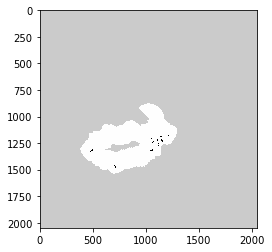

pgm height is:  2048


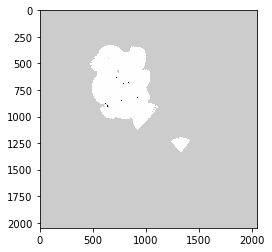

pgm height is:  2048


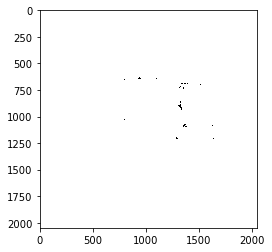

pgm height is:  2048


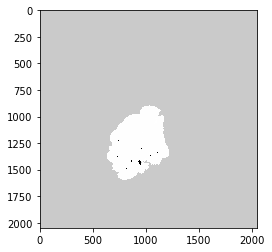

pgm height is:  2048


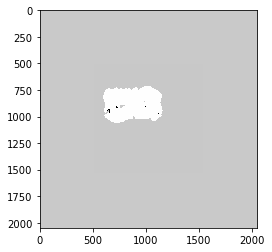

pgm height is:  2048


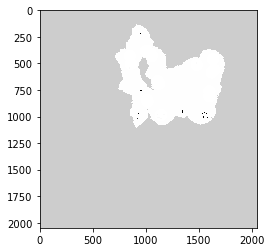

In [8]:
raw_pgm_dict = {}
for item in file_name.keys():
    map_source_dir = '/home/ncslaber/110-1/211002_allLibrary/'
    file_path = map_source_dir + '/' + file_name[item] 
    raw_pgm = cv2.imread(file_path+"/1116_test2_after_preprocess/raw_modified.png")
    if raw_pgm is None:
        print("Image is empty " + file_path+"/1116_test2_after_preprocess/raw_modified.png")
    raw_pgm = cv2.cvtColor(raw_pgm, cv2.COLOR_RGB2GRAY)
    raw_pgm_cvt = cvt_gray_map(raw_pgm)
    raw_pgm_dict[item] = raw_pgm_cvt
    (width, height) = raw_pgm.shape # the order is right
    print("pgm height is: ",height)
    # raw_pgm = cv2.resize(raw_pgm, (1024, 1024), interpolation=cv2.INTER_AREA)
    plt.imshow(cv2.cvtColor(raw_pgm, cv2.COLOR_BGR2RGB))
    plt.show()

In [9]:
num = (raw_pgm_dict['middle'][raw_pgm_dict['middle']==0]).shape[0] \
+ (raw_pgm_dict['middle'][raw_pgm_dict['middle']==255]).shape[0] \
+ (raw_pgm_dict['middle'][raw_pgm_dict['middle']==254]).shape[0] \
+ (raw_pgm_dict['middle'][raw_pgm_dict['middle']==253]).shape[0] \
+ (raw_pgm_dict['middle'][raw_pgm_dict['middle']==251]).shape[0] \
+ (raw_pgm_dict['middle'][raw_pgm_dict['middle']==203]).shape[0]

num, 2048*2048

(3881139, 4194304)

## check relative position

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(0, 101, 20)
minor_ticks = np.arange(0, 101, 5)

# ax.set_xticks(major_ticks)
# ax.set_xticks(minor_ticks, minor=True)
# ax.set_yticks(major_ticks)
# ax.set_yticks(minor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

plt.show()

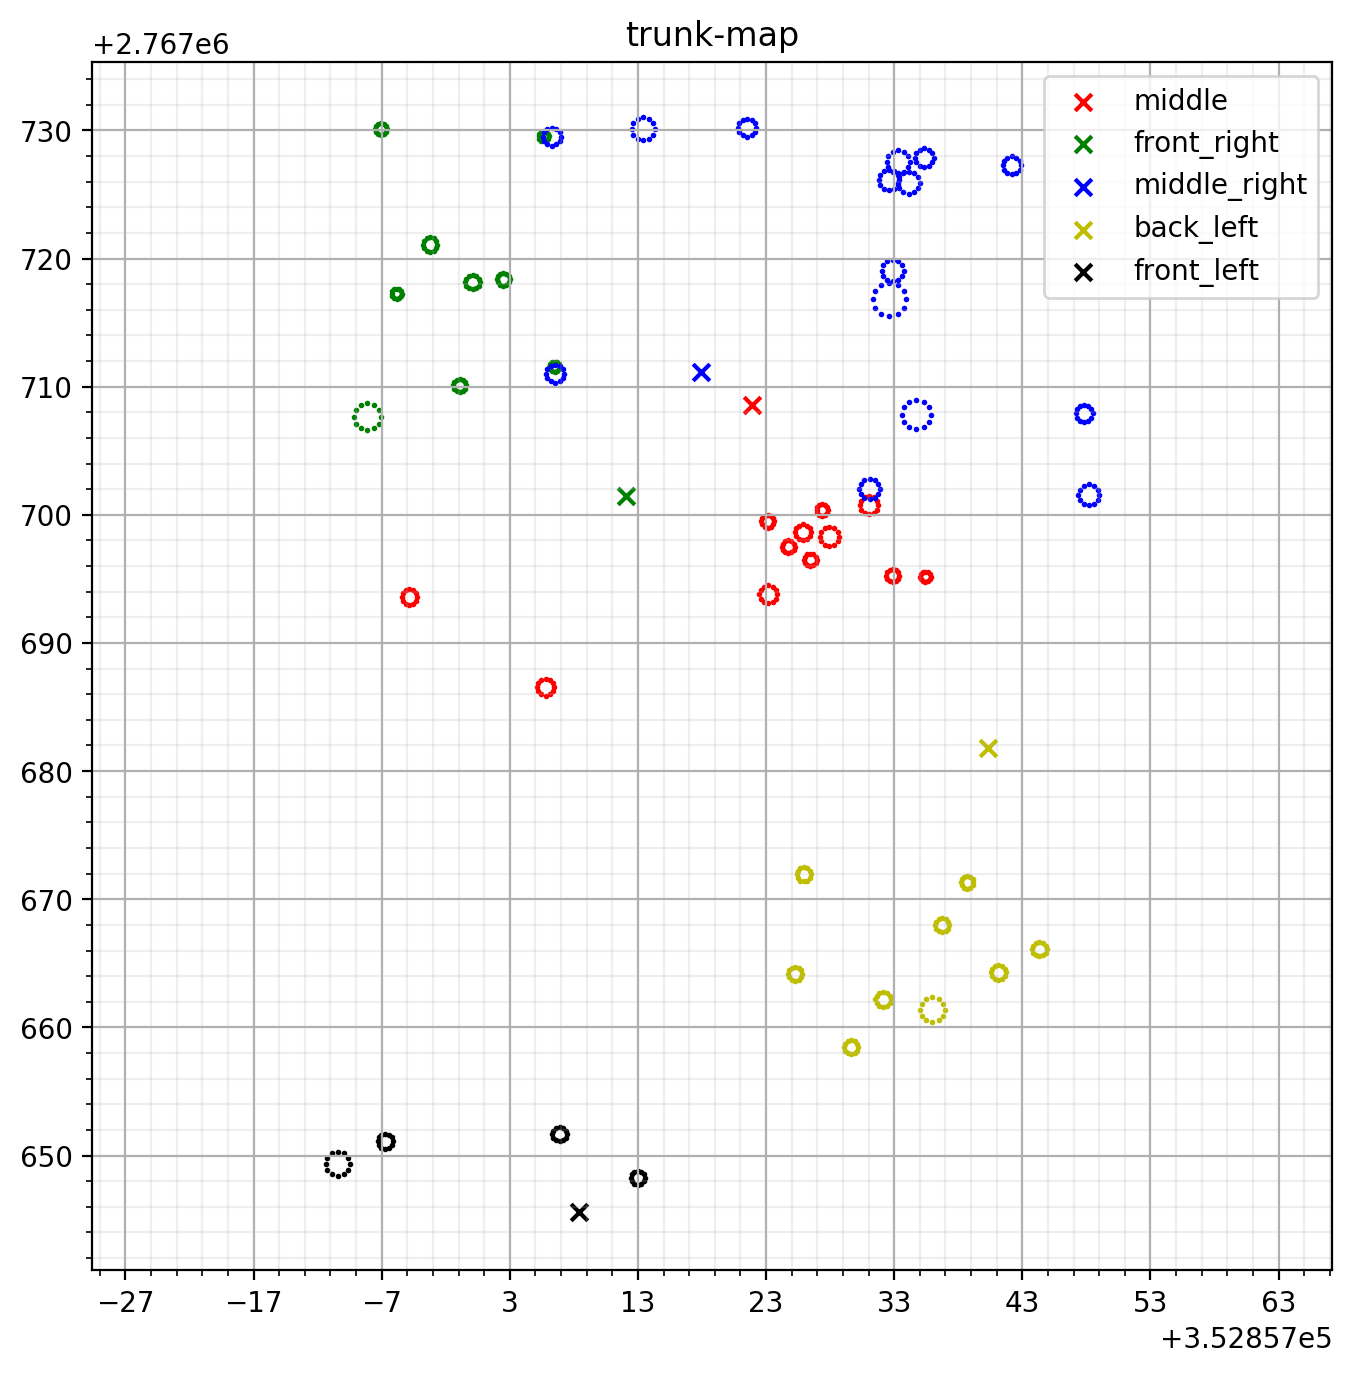

({'middle': [352878.8862176978],
  'front_right': [352869.03876166826],
  'middle_right': [352874.9314219437],
  'back_left': [352897.338491822],
  'front_left': [352865.3782908574]},
 {'middle': [2767708.6000474878],
  'front_right': [2767701.4516908275],
  'middle_right': [2767711.122274709],
  'back_left': [2767681.8378069475],
  'front_left': [2767645.5600058394]})

In [25]:
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig3, ax3 = plt.subplots(figsize=(8, 8),dpi=200)

file_name = {'middle':'2021-10-02-17-54-09', 'front_right':'2021-10-02-17-03-14', 
            'middle_right':'2021-10-02-17-29-15', 'back_left':'2021-10-03-17-48-23', 
             'front_left':'2021-07-25-18-23-39'}

utm_start_x_dict = {}
utm_start_y_dict = {}
num_trunk = [12,9,15,9,4]
color = ['r','g','b','y', 'k']
for index, item in enumerate(file_name.keys()):
    shp_path = '/home/ncslaber/110-1/211002_allLibrary/'+file_name[item]+'/1116_test2_after_preprocess/shapefiles/'
    for i in range(num_trunk[index]):
        neg_bd = np.load(shp_path+'neg_'+str(i+1)+'_bd_utm.npy')
        plt.scatter(neg_bd[:,0], neg_bd[:,1], s=1, c=color[index])

    lat_start = np.mean(lat_dict[item][:25])
    lng_start = np.mean(lng_dict[item][:25])
    utm_start_x, utm_start_y = transform_to_utm_npy([lat_start], [lng_start])
    utm_start_x_dict[item] = utm_start_x
    utm_start_y_dict[item] = utm_start_y
    plt.scatter(utm_start_x, utm_start_y, label=item, c=color[index], marker='x')
    
# for item in lat_dict.keys():
#     utm_x_traj, utm_y_traj = get_init_utm_npy(lat_dict[item], lng_dict[item])
#     traj(utm_x_traj,utm_y_traj, item)
plt.legend()

ax3.grid(True)
ax3.axis('equal')
ax3.get_xaxis().get_major_formatter().set_useOffset(
            round(min(utm_x_traj) / 1000, 3)*1000)

ax3.xaxis.set_major_locator(MultipleLocator(10))
ax3.yaxis.set_major_locator(MultipleLocator(10))

# Change minor ticks to show every 5. (20/4 = 5)
ax3.xaxis.set_minor_locator(AutoMinorLocator(5))
ax3.yaxis.set_minor_locator(AutoMinorLocator(5))

ax3.grid(which='minor', alpha=0.2)
ax3.grid(which='major', alpha=1)
plt.title('trunk-map')
plt.show()
utm_start_x_dict, utm_start_y_dict

In [ ]:
fig3, ax3 = plt.subplots(figsize=(8, 8),dpi=80)
utm_start_x_dict = {}
utm_start_y_dict = {}
num_trunk = [10,9,16,9,4]
item = 'front_right'
index = 1
shp_path = '/home/ncslaber/110-1/211002_allLibrary/'+file_name[item]+'/1116_test2_after_preprocess/shapefiles/'
for i in range(num_trunk[index]):
    neg_bd = np.load(shp_path+'neg_'+str(i+1)+'_bd_utm.npy')
    plt.scatter(neg_bd[:,0], neg_bd[:,1])

lat_start = np.mean(lat_dict[item][:25])
lng_start = np.mean(lng_dict[item][:25])
utm_start_x, utm_start_y = get_init_utm_npy([lat_start], [lng_start])
utm_start_x_dict[item] = utm_start_x
utm_start_y_dict[item] = utm_start_y
plt.scatter(utm_start_x, utm_start_y, label=item)
    

utm_x_traj, utm_y_traj = get_init_utm_npy(lat_dict[item], lng_dict[item])
traj(utm_x_traj,utm_y_traj, item)
plt.legend()
plt.show()
utm_start_x_dict, utm_start_y_dict

In [ ]:
fig3, ax3 = plt.subplots(figsize=(8, 8),dpi=80)
utm_start_x_dict = {}
utm_start_y_dict = {}
num_trunk = [10,9,15,9,4]
item = 'middle'
index = 0
shp_path = '/home/ncslaber/110-1/211002_allLibrary/'+file_name[item]+'/1116_test2_after_preprocess/shapefiles/'
for i in range(num_trunk[index]):
    neg_bd = np.load(shp_path+'neg_'+str(i+1)+'_bd_utm.npy')
    plt.scatter(neg_bd[:,0], neg_bd[:,1])

lat_start = np.mean(lat_dict[item][:25])
lng_start = np.mean(lng_dict[item][:25])
utm_start_x, utm_start_y = get_init_utm_npy([lat_start], [lng_start])
utm_start_x_dict[item] = utm_start_x
utm_start_y_dict[item] = utm_start_y
plt.scatter(utm_start_x, utm_start_y, label=item)
    

utm_x_traj, utm_y_traj = get_init_utm_npy(lat_dict[item], lng_dict[item])
traj(utm_x_traj,utm_y_traj, item)
plt.legend()
plt.show()
utm_start_x_dict, utm_start_y_dict

In [ ]:
fig3, ax3 = plt.subplots(figsize=(8, 8),dpi=80)
utm_start_x_dict = {}
utm_start_y_dict = {}
num_trunk = [10,9,16,9,4]
item = 'back_left'
index = 1
shp_path = '/home/ncslaber/110-1/211002_allLibrary/'+file_name[item]+'/1116_test2_after_preprocess/shapefiles/'
for i in range(num_trunk[index]):
    neg_bd = np.load(shp_path+'neg_'+str(i+1)+'_bd_utm.npy')
    plt.scatter(neg_bd[:,0], neg_bd[:,1])

lat_start = np.mean(lat_dict[item][:25])
lng_start = np.mean(lng_dict[item][:25])
utm_start_x, utm_start_y = get_init_utm_npy([lat_start], [lng_start])
utm_start_x_dict[item] = utm_start_x
utm_start_y_dict[item] = utm_start_y
plt.scatter(utm_start_x, utm_start_y, label=item)
    

utm_x_traj, utm_y_traj = get_init_utm_npy(lat_dict[item], lng_dict[item])
traj(utm_x_traj,utm_y_traj, item)
plt.legend()
plt.show()
utm_start_x_dict, utm_start_y_dict

In [ ]:
fig3, ax3 = plt.subplots(figsize=(8, 8),dpi=80)
utm_start_x_dict = {}
utm_start_y_dict = {}
num_trunk = [10,9,15,9,4]
item = 'middle_right'
index = 2
shp_path = '/home/ncslaber/110-1/211002_allLibrary/'+file_name[item]+'/1116_test2_after_preprocess/shapefiles/'
for i in range(num_trunk[index]):
    neg_bd = np.load(shp_path+'neg_'+str(i+1)+'_bd_utm.npy')
    plt.scatter(neg_bd[:,0], neg_bd[:,1])

lat_start = np.mean(lat_dict[item][:25])
lng_start = np.mean(lng_dict[item][:25])
utm_start_x, utm_start_y = get_init_utm_npy([lat_start], [lng_start])
utm_start_x_dict[item] = utm_start_x
utm_start_y_dict[item] = utm_start_y
plt.scatter(utm_start_x, utm_start_y, label=item)
    

utm_x_traj, utm_y_traj = get_init_utm_npy(lat_dict[item], lng_dict[item])
traj(utm_x_traj,utm_y_traj, item)
plt.legend()
plt.show()
utm_start_x_dict, utm_start_y_dict

In [ ]:
num_trunk = [10,9,15,9,4]
center_list_all = []
for index, item in enumerate(file_name.keys()):
#     print(index, item)
    shp_path = '/home/ncslaber/110-1/211002_allLibrary/'+file_name[item]+'/1116_test2_after_preprocess/shapefiles/'
    for a in range(num_trunk[index]):
#         print(num_trunk[index-1], a, list(range(num_trunk[index-1])) )
        tmp = list(np.load(shp_path+'center_'+str(a+1)+'_bd_utm.npy'))
        center_list_all.append(tmp)

In [ ]:
num_trunk = [10,9,15,9,4]
center_list_all = []
item = 'middle'
index=0
shp_path = '/home/ncslaber/110-1/211002_allLibrary/'+file_name[item]+'/1116_test2_after_preprocess/shapefiles/'
for a in range(num_trunk[index]):
#         print(num_trunk[index-1], a, list(range(num_trunk[index-1])) )
    tmp = np.load(shp_path+'neg_'+str(i+1)+'_bd_utm.npy')
    center_list_all.append(tmp)
    print(type(tmp), tmp)

center_list_all

In [23]:
num_trunk = [10,9,15,9,4,2]
center_list_all = []
item = 'middle_middle'
index=5
shp_path = '/home/ncslaber/110-1/211002_allLibrary/'+file_name[item]+'/1116_test2_after_preprocess/shapefiles/'
for a in range(num_trunk[index]):
#         print(num_trunk[index-1], a, list(range(num_trunk[index-1])) )
    tmp = np.load(shp_path+'neg_'+str(a+1)+'_bd_utm.npy')  + np.array([0,-1])
    np.save(shp_path+'neg_'+str(a+1)+'_bd_utm',tmp)
#     center_list_all.append(tmp)
    print(type(tmp), tmp)

# center_list_all

<class 'numpy.ndarray'> [[ 352890.3863806  2767695.26658497]
 [ 352890.3193933  2767695.51658497]
 [ 352890.1363806  2767695.69959768]
 [ 352889.8863806  2767695.76658497]
 [ 352889.6363806  2767695.69959768]
 [ 352889.4533679  2767695.51658497]
 [ 352889.3863806  2767695.26658497]
 [ 352889.4533679  2767695.01658497]
 [ 352889.6363806  2767694.83357227]
 [ 352889.8863806  2767694.76658497]
 [ 352890.1363806  2767694.83357227]
 [ 352890.3193933  2767695.01658497]]
<class 'numpy.ndarray'> [[ 352892.8363806  2767695.16658497]
 [ 352892.78279076 2767695.36658497]
 [ 352892.6363806  2767695.51299514]
 [ 352892.4363806  2767695.56658497]
 [ 352892.2363806  2767695.51299514]
 [ 352892.08997044 2767695.36658497]
 [ 352892.0363806  2767695.16658497]
 [ 352892.08997044 2767694.96658497]
 [ 352892.2363806  2767694.82017481]
 [ 352892.4363806  2767694.76658497]
 [ 352892.6363806  2767694.82017481]
 [ 352892.78279076 2767694.96658497]]


In [ ]:
shp_path, shp_path+'center_'+str(a+1)

In [ ]:
np.save('/home/ncslaber/center_list_all.npy',center_list_all)

#### change to relative coordinate

In [26]:
bd_left = utm_start_x_dict['front_left'][0]
bd_top = utm_start_y_dict['middle_right'][0]
relative_mapWorld = {}
for item in utm_start_x_dict.keys():
    relative_mapWorld[item] = \
        [round((utm_start_x_dict[item][0]-bd_left)*20), round((bd_top - utm_start_y_dict[item][0])*20)]
relative_mapWorld

{'middle': [270, 50],
 'front_right': [73, 193],
 'middle_right': [191, 0],
 'back_left': [639, 586],
 'front_left': [0, 1311]}

## open a canvas

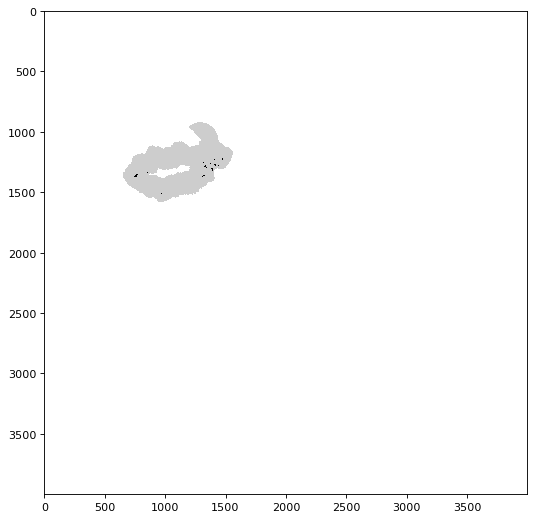

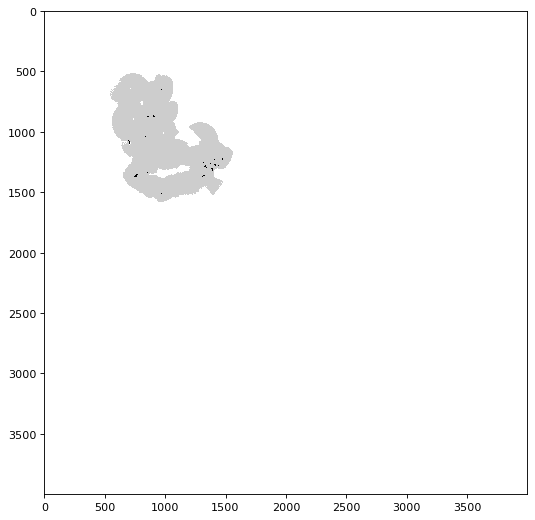

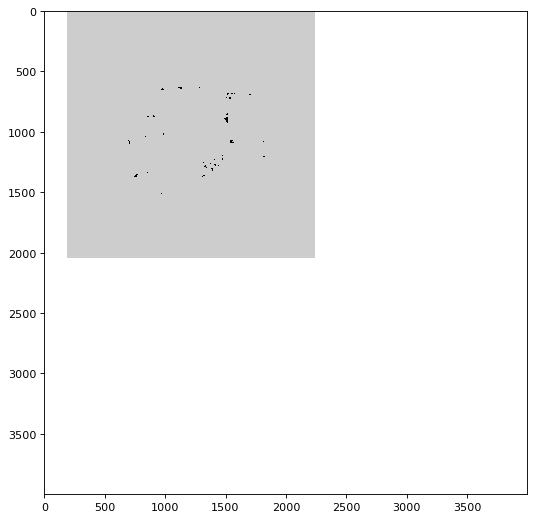

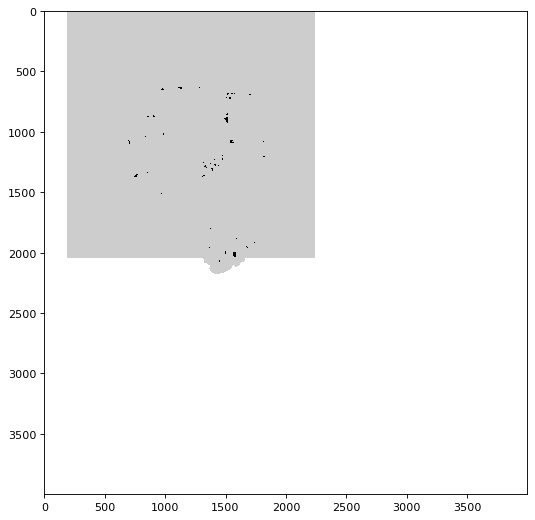

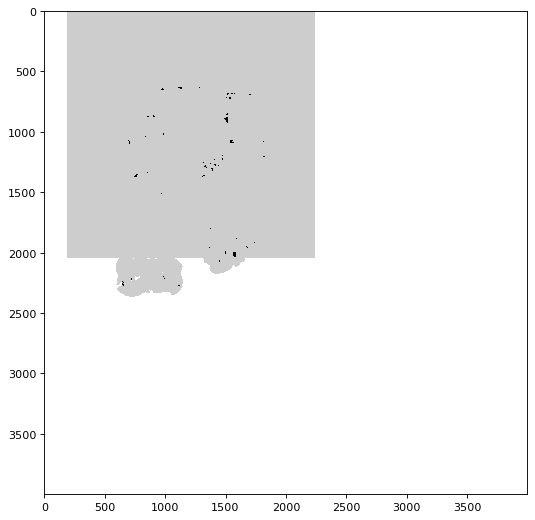

In [40]:
map_canvas = np.zeros((4000,4000), dtype='uint8')
map_canvas = map_canvas + 255
for item in utm_start_x_dict.keys():
    fig3, ax3 = plt.subplots(figsize=(8, 8),dpi=80)
    offset_x, offset_y = relative_mapWorld[item]
    offset_x_end, offset_y_end = offset_x+2048, offset_y+2048
    
    if item == 'middle':
        map_canvas[offset_y:offset_y_end, offset_x:offset_x_end] = \
            cv2.bitwise_and(map_canvas[offset_y:offset_y_end, offset_x:offset_x_end], raw_pgm_dict[item])
    else:
        map_canvas[offset_y:offset_y_end, offset_x:offset_x_end] = \
            cv2.bitwise_and(map_canvas[offset_y:offset_y_end, offset_x:offset_x_end], raw_pgm_dict[item])
    plt.imshow(cv2.cvtColor(map_canvas, cv2.COLOR_BGR2RGB))
    plt.show()

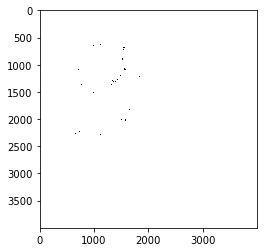

True

In [42]:
map_canvas[map_canvas!=0]=255
plt.imshow(cv2.cvtColor(map_canvas, cv2.COLOR_BGR2RGB))
plt.show()
cv2.imwrite('/home/ncslaber/1118.png',map_canvas[:2500,:2000])

## merge 2 map

In [ ]:
file_path = '/home/ncslaber/110-1/211002_allLibrary/2021-07-25-18-23-39/1116_test2_after_preprocess/' #directory+bag_name
raw_pgm = cv2.imread(file_path+"raw_modified.png")
raw_pgm = cv2.cvtColor(raw_pgm, cv2.COLOR_RGB2GRAY)
tmp = np.zeros((2048,2048), dtype='uint8')+ 204

tmp[512:512+1024,512:512+1024] = raw_pgm
cv2.imwrite(file_path+"raw_modified2.png",tmp)

In [ ]:
file_path = '/home/ncslaber/110-1/211002_allLibrary/2021-10-02-17-03-14/dif_height_map/' #directory+bag_name
raw_pgm_57 = cv2.imread(file_path+"height50-70.pgm")
raw_pgm_color_57 = np.zeros(raw_pgm_57.shape,dtype=np.uint8) + 255

raw_pgm_79 = cv2.imread(file_path+"height70-90.pgm")
raw_pgm_color_79 = np.zeros(raw_pgm_79.shape,dtype=np.uint8) + 255

raw_pgm_57 = cv2.cvtColor(raw_pgm_57, cv2.COLOR_RGB2GRAY)
raw_pgm_79 = cv2.cvtColor(raw_pgm_79, cv2.COLOR_RGB2GRAY)

In [ ]:
tmp = cv2.bitwise_and(raw_pgm1,raw_pgm2)
plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))
plt.show()
cv2.imwrite(file_path+"raw_modified2.png",tmp)

In [ ]:
# raw_pgm_color_35[raw_pgm_35==0]=(0,0,255)
raw_pgm_color_57[raw_pgm_57==0]=(0,255,0)
raw_pgm_color_79[raw_pgm_79==0]=(255,0,0)

accu_map = cv2.bitwise_and(raw_pgm_color_57, raw_pgm_color_79)
fig3, ax3 = plt.subplots(figsize=(8, 8),dpi=200)
plt.imshow(cv2.cvtColor(accu_map[400:1100,900:1900], cv2.COLOR_BGR2RGB))
cv2.imwrite(file_path+"raw_modified2.png",accu_map[400:1100,900:1900])